# Explainability for the Zoning model

This notebook demonstrates how the handler `SearchForExplanation` can be used on models that have been learned from data. It also documents the issues that still need to be solved for an effective use of the handler for large scale models.

We first have an initial setup that extracts the data, defines the model and trains the latter using variational inference.

In [1]:
from typing import Optional, Callable
import math
import copy
import os

import dill
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import seaborn as sns
import torch
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers.predictive import PredictiveModel
from pyro.infer import Predictive
from torch.utils.data import DataLoader

from cities.modeling.evaluation import prep_data_for_test, test_performance
from cities.modeling.svi_inference import run_svi_inference

from cities.modeling.zoning_models.zoning_tracts_sqm_model import TractsModelSqm
from cities.utils.data_loader import select_from_data
from chirho.observational.handlers import condition

smoke_test = "CI" in os.environ

n_steps = 10 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
# Extracting data
census_tracts_data_path = os.path.join(
    root, "data/minneapolis/processed/pg_census_tracts_dataset.pt"
)

ct_dataset_read = torch.load(census_tracts_data_path)
ct_loader = DataLoader(ct_dataset_read, batch_size=len(ct_dataset_read), shuffle=True)
data = next(iter(ct_loader))

kwargs = {
    "categorical": ["year", "census_tract"],
    "continuous": {
        "housing_units",
        "total_value",
        "median_value",
        "mean_limit_original",
        "median_distance",
        "income",
        "segregation_original",
        "white_original",
        'parcel_mean_sqm',
        'parcel_median_sqm',
        'parcel_sqm',
    },
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)

/var/folders/pq/ntbz4ft13jv662kczkzk32pr0000gn/T/ipykernel_22598/3231267863.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ct_dataset_read = torch.load(census_tracts_da

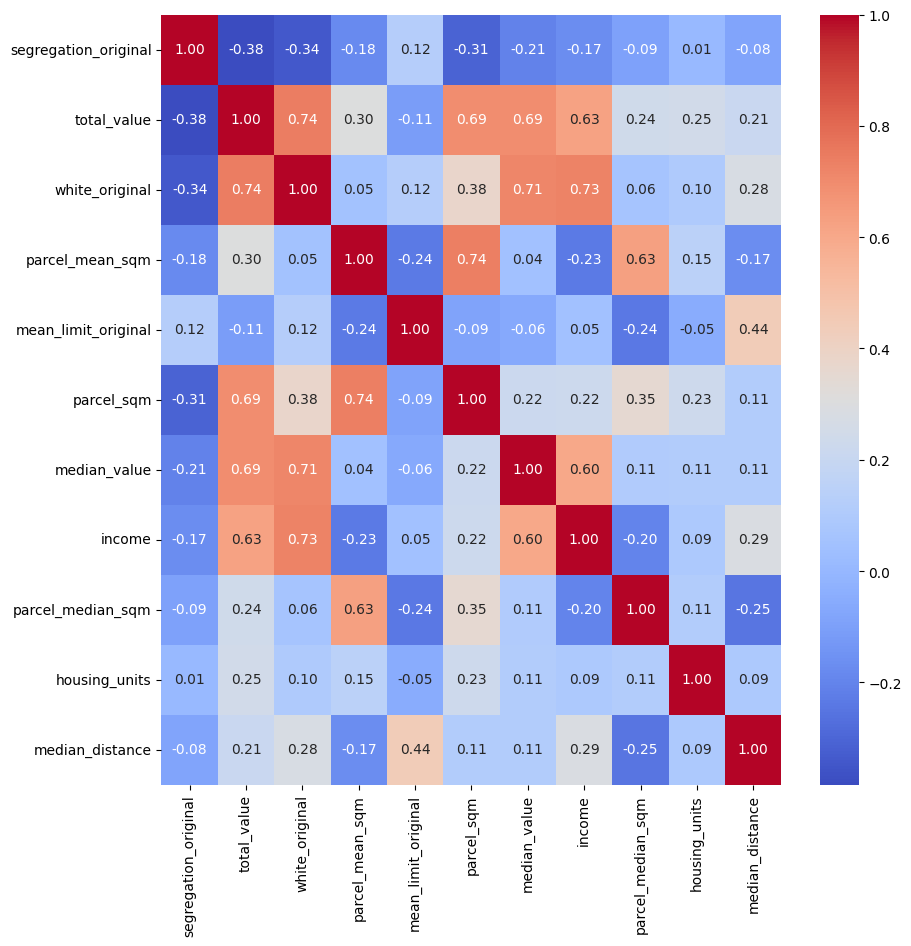

In [3]:
# Visualizing correlations between different columns in the data

subset_continuous = subset['continuous']

continuous_np = {key: tensor.numpy() for key, tensor in subset_continuous.items()}
df = pd.DataFrame(continuous_np)
# columns_to_drop = ['column1', 'column2']
# df = df.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' avoids issues if the columns don't exist

columns = df.columns

vars_to_remove = ["census_tract", "year", "year_id"] + [
    var for var in columns if var.endswith("std")
]

vars = [var for var in columns if var not in vars_to_remove]
# plot spearman correlation between all vars in census[vars]
corr = df[vars].corr(method="spearman")

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


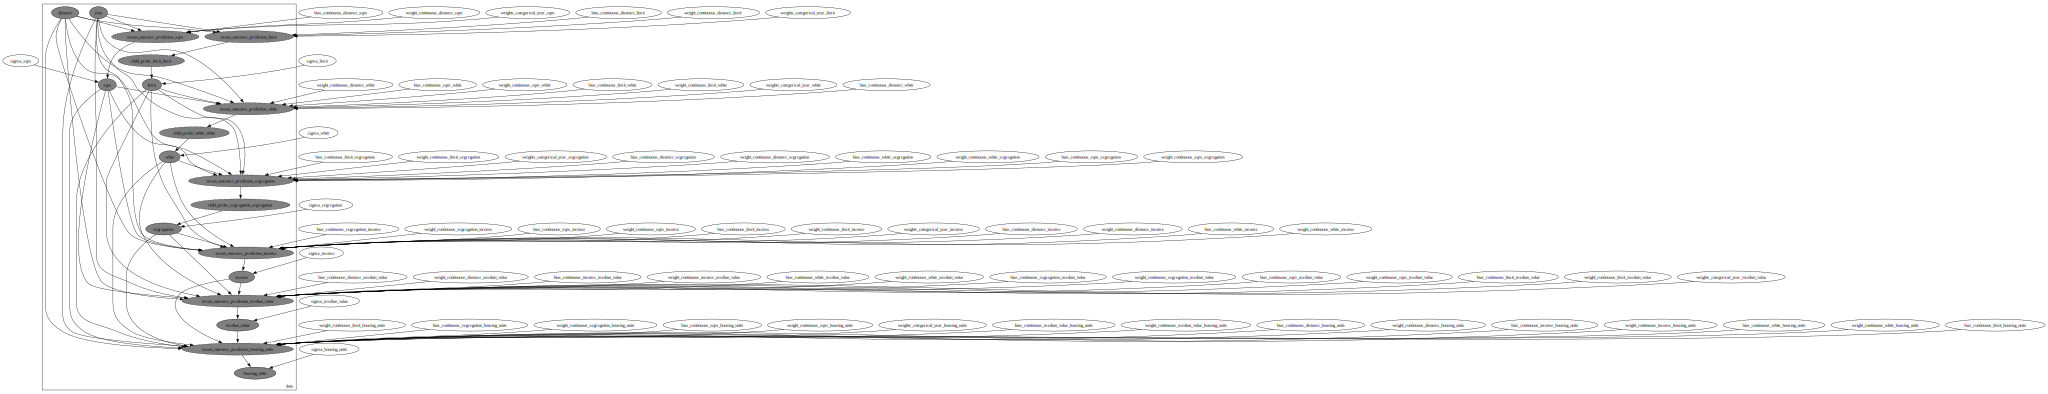

In [4]:
# instantiation and prior predictive run

tracts_model = TractsModelSqm(
    **subset, categorical_levels=ct_dataset_read.categorical_levels
)

with pyro.poutine.trace() as tr:
    tracts_model(**subset)

assert tr.trace.nodes["housing_units"]["value"].shape == torch.Size([1130])

pyro.render_model(
    lambda: tracts_model(**subset),
    render_deterministic=True,
)

In [5]:
def destandardize_housing_units(column):
    mean = ct_dataset_read.standardization_dictionary["housing_units_original"]["mean"]
    std = ct_dataset_read.standardization_dictionary["housing_units_original"]["std"]

    return (column * std + mean).round()

[iteration 0001] loss: 369698.6875
[iteration 0050] loss: 31719.4844
[iteration 0100] loss: 20565.9434
[iteration 0150] loss: 12465.4961
[iteration 0200] loss: 10967.1299
[iteration 0250] loss: 10731.8867
[iteration 0300] loss: 9860.0996
[iteration 0350] loss: 9586.0781
[iteration 0400] loss: 9370.4990
[iteration 0450] loss: 9471.8027
[iteration 0500] loss: 9240.0898
[iteration 0550] loss: 9170.0439
[iteration 0600] loss: 9319.2275
[iteration 0650] loss: 9136.6582
[iteration 0700] loss: 9118.4150
[iteration 0750] loss: 9100.4365
[iteration 0800] loss: 9075.5859
[iteration 0850] loss: 9187.4541
[iteration 0900] loss: 9123.2881
[iteration 0950] loss: 8995.6436
[iteration 1000] loss: 9026.1572
[iteration 1050] loss: 9171.7510
[iteration 1100] loss: 8999.4854
[iteration 1150] loss: 9028.2324
[iteration 1200] loss: 9130.0752
[iteration 1250] loss: 8987.3838
[iteration 1300] loss: 8972.0791
[iteration 1350] loss: 8968.2803
[iteration 1400] loss: 8913.5391
[iteration 1450] loss: 8966.9473
[it

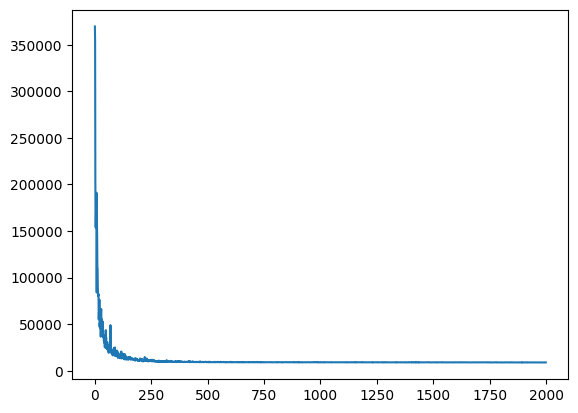

In [6]:
pyro.clear_param_store()
n_steps = 2000
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset)

predictive = Predictive(tracts_model, guide=guide, num_samples=num_samples)


In [7]:
if not smoke_test:
    serialized_guide = dill.dumps(guide)
    file_path = os.path.join(root, "data/minneapolis/guides", f"tracts_sqm_model_guide_pg.pkl")
    with open(file_path, "wb") as file:
        file.write(serialized_guide)

    param_path = os.path.join(
        root, "data/minneapolis/guides", "tracts_sqm_model_params_pg.pth"
    )

    pyro.get_param_store().save(param_path)

In [8]:
subset_for_preds = copy.deepcopy(subset)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds["continuous"][var] = None


## Explainability Queries

Now that we have trained the model on data, the following code uses the trained model for explanations. It currently combines the learned guide and model to get the new model and then transforms the model using `SearchForExplanation`. It then uses importance sampling through the transformed model to get joint distributions over the possible explanations (or causal sets).

In [9]:
from chirho.explainable.handlers import SearchForExplanation
from chirho.explainable.handlers.components import ExtractSupports

BATCH_SIZE=1
NSAMPLES=1000
DIM = -10

In [10]:
import torch
from copy import deepcopy
from cities.modeling.model_components import get_n

def recurse_dict(d, fn):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = fn(v)
        elif isinstance(v, dict):
            d[k] = recurse_dict(v, fn)
    return d

def nonify_dict_(d):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = None
        elif isinstance(v, dict):
            d[k] = nonify_dict_(v)
    return d


def nonify_dict(d):
    d = deepcopy(d)
    return nonify_dict_(d)


SUBSET_SITE_NAME_MAP = {
    "white": "white_original",
    "segregation": "segregation_original",
    "limit": "mean_limit_original",
    "distance": "median_distance",
}


def map_subset_onto_obs(subset, site_names):
    obs = dict()

    for name in site_names:
        subset_name = SUBSET_SITE_NAME_MAP.get(name, name)
        for k, inner_subset_dict in subset.items():
            if k == "outcome":
                continue
            if subset_name in inner_subset_dict:
                obs[name] = inner_subset_dict[subset_name]
                break

    assert obs.keys() == set(site_names), f"Missing keys: {set(site_names) - obs.keys()}"
    return obs

The following code extracts a single datapoint (or the factual world) where we wish to find causal explanations. It further pads it with appropriate number of dimensions to make it compatible with the stochastic interventions induced by `SearchForExplanation`. Ideally, this expansion should not be required on the user's end.

**TODO**: Do away with the broadcasting of observations to the required tensor shape

In [11]:
ct_loader_query = DataLoader(ct_dataset_read, batch_size=BATCH_SIZE, shuffle=True)
data_query = next(iter(ct_loader_query))

subset_query = select_from_data(data_query, kwargs)

subset_for_preds_query = copy.deepcopy(subset_query)
vars_to_suspend = ["housing_units"] #, "white", "segregation", "income", "median_value"]

for var in vars_to_suspend:
    subset_for_preds_query["continuous"][var] = None

broadcast_data_over_samples = lambda t: t.expand((NSAMPLES, *((1,)*(abs(DIM)-2)), t.shape[-1]))
subset_broadcast = copy.deepcopy(subset_for_preds_query)
recurse_dict(subset_broadcast, broadcast_data_over_samples)

subset_none = nonify_dict(subset_for_preds_query)

The following code extracts the supports from the model and then transform the model using the handler.

In [12]:
predictive = PredictiveModel(tracts_model, guide=guide)

with ExtractSupports() as s:
    predictive(**subset_broadcast, n=BATCH_SIZE)

print(s.supports)

{'_AutoMultivariateNormal_latent': IndependentConstraint(Real(), 1), 'sigma_sqm': IndependentConstraint(Real(), 0), 'bias_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weight_continuous_distance_sqm': IndependentConstraint(Real(), 0), 'weights_categorical_year_sqm': IndependentConstraint(Real(), 1), 'bias_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weight_continuous_distance_limit': IndependentConstraint(Real(), 0), 'weights_categorical_year_limit': IndependentConstraint(Real(), 1), 'sigma_limit': IndependentConstraint(Real(), 0), 'bias_continuous_distance_white': IndependentConstraint(Real(), 0), 'weight_continuous_distance_white': IndependentConstraint(Real(), 0), 'bias_continuous_sqm_white': IndependentConstraint(Real(), 0), 'weight_continuous_sqm_white': IndependentConstraint(Real(), 0), 'bias_continuous_limit_white': IndependentConstraint(Real(), 0), 'weight_continuous_limit_white': IndependentConstraint(Real(), 0), 'weights_categorical_year_white

In [13]:
query = SearchForExplanation(
        supports=s.supports,
        antecedents = {"income": None, "distance": None, "sqm": None, "limit": None, "white":None, "segregation": None, "median_value":None},
        # antecedents={"income": None},
        consequents={"housing_units": None},
        witnesses={"income": None, "distance": None, "sqm": None, "limit": None, "white": None, "segregation": None, "median_value": None},
        consequent_scale=1,
    )(predictive)

Now that we have the transformed model `query`, we can sample through this model to get a posterior distribution on the causal explanations.

In [14]:
def importance_infer(
    model: Optional[Callable] = None, *, num_samples: int
):
    
    if model is None:
        return lambda m: importance_infer(m, num_samples=num_samples)

    def _wrapped_model(
        *args,
        **kwargs
    ):

        guide = pyro.poutine.block(hide_fn=lambda msg: msg["is_observed"])(model)

        max_plate_nesting = abs(DIM)-1 # TODO guess

        with pyro.poutine.block(), MultiWorldCounterfactual(first_available_dim=-2) as mwc:
            log_weights, importance_tr, _ = pyro.infer.importance.vectorized_importance_weights(
                model,
                guide,
                *args,
                num_samples=num_samples,
                max_plate_nesting=max_plate_nesting,
                normalized=False,
                **kwargs
            )

        return torch.logsumexp(log_weights, dim=0), importance_tr, mwc, log_weights

    return _wrapped_model

In [15]:
logp, trace, mwc, log_weights = importance_infer(num_samples=NSAMPLES)(query)(**subset_broadcast, n=BATCH_SIZE)


/Users/Admin/Desktop/basis/pyro/pyro/util.py:284: UserWarning: Found auxiliary vars in the model: {'_AutoMultivariateNormal_latent'}
  warnings.warn(


In [16]:
a = (torch.exp(log_weights - logp))
for i in range(len(a)):
    if a[i] > 0.0001:
        print(i)
        print(a[i])
        causes = []
        for j in trace.nodes.keys():
            if 'cause' in j and 'antecedent' in j:
                if trace.nodes[j]['value'][i] == 0:
                    causes.append(j)
        print(causes)

927
tensor(1., grad_fn=<SelectBackward0>)
['__cause____antecedent_distance', '__cause____antecedent_segregation', '__cause____antecedent_median_value']


The above code computes how many samples have the probability assigned that is greater than `0.0001`. There is only one out of 1000 samples that satisfy this property. This is not desirable. We ideally want more number of samples from higher probability regions. 

**TODO**: To achieve this, there is a need of experimenting with different inference algorithms that target this task such as variational inference, hamiltonian monte carlo etc.

Below is an attempt at learning a guide distribution to direct sampling towards high probability distribution but it currently runs into error.

[iteration 0001] loss: 549.8887
[iteration 0050] loss: 227.9823
[iteration 0100] loss: 189.5419
[iteration 0150] loss: 172.2585
[iteration 0200] loss: 157.4591
[iteration 0250] loss: 144.1411
[iteration 0300] loss: 141.1051
[iteration 0350] loss: 123.9548
[iteration 0400] loss: 106.7258
[iteration 0450] loss: 132.9954
[iteration 0500] loss: 128.5045
[iteration 0550] loss: 120.4684
[iteration 0600] loss: 116.3248
[iteration 0650] loss: 110.1962
[iteration 0700] loss: 112.7963
[iteration 0750] loss: 137.8479
[iteration 0800] loss: 110.6289
[iteration 0850] loss: 98.3906
[iteration 0900] loss: 82.4456
[iteration 0950] loss: 119.8798
[iteration 1000] loss: 137.8083
[iteration 1050] loss: 107.3086
[iteration 1100] loss: 118.5028
[iteration 1150] loss: 123.4076
[iteration 1200] loss: 101.6404
[iteration 1250] loss: 120.8989
[iteration 1300] loss: 103.3461
[iteration 1350] loss: 118.5749
[iteration 1400] loss: 120.5555
[iteration 1450] loss: 139.3569
[iteration 1500] loss: 101.6631
[iteration

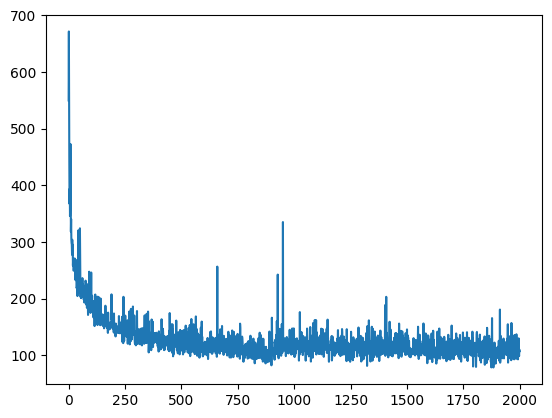

In [19]:
pyro.clear_param_store()
n_steps = 2000
guide = run_svi_inference(tracts_model, n_steps=n_steps, lr=0.03, **subset_for_preds_query, n=BATCH_SIZE)

In [20]:
explained_predictive = PredictiveModel(query, guide)

In [23]:
explained_predictive(**subset_broadcast, n=BATCH_SIZE)

AssertionError: 